# 1. Conhecendo a Base de Dados

In [0]:
dados = spark.read.table('workspace.default.insurance')
dados.show(5, False)

+---+------+------+--------+------+---------+-----------+
|age|sex   |bmi   |children|smoker|region   |charges    |
+---+------+------+--------+------+---------+-----------+
|19 |female|27.9  |0       |yes   |southwest|16884.924  |
|18 |male  |33.77 |1       |no    |southeast|1725.5523  |
|28 |male  |33.0  |3       |no    |southeast|4449.462   |
|33 |male  |22.705|0       |no    |northwest|21984.47061|
|32 |male  |28.88 |0       |no    |northwest|3866.8552  |
+---+------+------+--------+------+---------+-----------+
only showing top 5 rows


* Verificando os Tipos dos dados de cada Feature

In [0]:
dados.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



* Verificando o Total de Linhas e Colunas

In [0]:
print(f'Total Linhas : {dados.count()}')
print(f'Total de Colunas : {len(dados.columns)}')

Total Linhas : 1338
Total de Colunas : 7


* Verificando se o Dataset contém dados nulos

In [0]:
from pyspark.sql import functions as f

In [0]:
for coluna in dados.columns:
    print(f'{coluna} -> {dados.filter(f.col(coluna).isNull()).count()}')

age -> 0
sex -> 0
bmi -> 0
children -> 0
smoker -> 0
region -> 0
charges -> 0


* Verificando as informações dos dados numéricos

In [0]:
dados.describe().show()

+-------+------------------+------+------------------+------------------+------+---------+------------------+
|summary|               age|   sex|               bmi|          children|smoker|   region|           charges|
+-------+------------------+------+------------------+------------------+------+---------+------------------+
|  count|              1338|  1338|              1338|              1338|  1338|     1338|              1338|
|   mean| 39.20702541106129|  NULL|30.663396860986538|   1.0949177877429|  NULL|     NULL|13270.422265141257|
| stddev|14.049960379216172|  NULL| 6.098186911679017|1.2054927397819095|  NULL|     NULL|12110.011236693994|
|    min|                18|female|             15.96|                 0|    no|northeast|         1121.8739|
|    max|                64|  male|             53.13|                 5|   yes|southwest|       63770.42801|
+-------+------------------+------+------------------+------------------+------+---------+------------------+



# 2. Tratando os Dados para Analises Gráficas

In [0]:
dados\
    .groupBy('sex')\
    .count()\
    .show()

dados\
    .groupBy('smoker')\
    .count()\
    .show()

dados\
    .groupBy('region')\
    .count()\
    .show()

+------+-----+
|   sex|count|
+------+-----+
|female|  662|
|  male|  676|
+------+-----+

+------+-----+
|smoker|count|
+------+-----+
|   yes|  274|
|    no| 1064|
+------+-----+

+---------+-----+
|   region|count|
+---------+-----+
|southwest|  325|
|southeast|  364|
|northwest|  325|
|northeast|  324|
+---------+-----+



* Tratando as colunas SEX e SMOKER - deixando 0 e 1

In [0]:
dados.createOrReplaceTempView('dados')

In [0]:
dados = spark.sql('''
    SELECT *,
        CASE 
            WHEN sex = 'male' THEN 1
            ELSE 0
        END AS sex_tratado,

        CASE
            WHEN smoker = 'yes' THEN 1
            ELSE 0
        END AS smoker_tratado
    FROM dados
''')

dados = dados.drop('sex', 'smoker')

# Get Dummies

* Adicionando uma coluna de ID no dataset

In [0]:
from pyspark.sql.functions import monotonically_increasing_id

dados = dados.withColumn("id", monotonically_increasing_id())
dados.show(5, False)

+---+------+--------+---------+-----------+-----------+--------------+---+
|age|bmi   |children|region   |charges    |sex_tratado|smoker_tratado|id |
+---+------+--------+---------+-----------+-----------+--------------+---+
|19 |27.9  |0       |southwest|16884.924  |0          |1             |0  |
|18 |33.77 |1       |southeast|1725.5523  |1          |0             |1  |
|28 |33.0  |3       |southeast|4449.462   |1          |0             |2  |
|33 |22.705|0       |northwest|21984.47061|1          |0             |3  |
|32 |28.88 |0       |northwest|3866.8552  |1          |0             |4  |
+---+------+--------+---------+-----------+-----------+--------------+---+
only showing top 5 rows


* Criando 4 novas colunas, aonde for verdadeiro recebe 1 e as demais recebem 0

In [0]:
dados\
    .groupby('id')\
    .pivot('region')\
    .agg(f.lit(1))\
    .na\
    .fill(0)\
    .show(5, False)

+---+---------+---------+---------+---------+
|id |northeast|northwest|southeast|southwest|
+---+---------+---------+---------+---------+
|0  |0        |0        |0        |1        |
|1  |0        |0        |1        |0        |
|2  |0        |0        |1        |0        |
|3  |0        |1        |0        |0        |
|4  |0        |1        |0        |0        |
+---+---------+---------+---------+---------+
only showing top 5 rows


In [0]:
regiao = dados\
    .groupby('id')\
    .pivot('region')\
    .agg(f.lit(1))\
    .na\
    .fill(0)

In [0]:
regiao.columns

['id', 'northeast', 'northwest', 'southeast', 'southwest']

* Iremos juntar os DataFrame com o Join e remover as colunas que não precisa mais

In [0]:
dados = dados\
        .join(regiao, "id", how="inner")\
        .select(
            "*",
            f.col('northeast').alias('regiao_northeast'),
            f.col('northwest').alias('regiao_northwest'),
            f.col('southeast').alias('regiao_southeast'),
            f.col('southwest').alias('regiao_southwest')
                 
        ).drop(
            'northeast', 'northwest', 'southeast', 'southwest', 'region'
        )

In [0]:
dados.show(5, False)

+---+---+------+--------+-----------+-----------+--------------+----------------+----------------+----------------+----------------+
|id |age|bmi   |children|charges    |sex_tratado|smoker_tratado|regiao_northeast|regiao_northwest|regiao_southeast|regiao_southwest|
+---+---+------+--------+-----------+-----------+--------------+----------------+----------------+----------------+----------------+
|0  |19 |27.9  |0       |16884.924  |0          |1             |0               |0               |0               |1               |
|1  |18 |33.77 |1       |1725.5523  |1          |0             |0               |0               |1               |0               |
|2  |28 |33.0  |3       |4449.462   |1          |0             |0               |0               |1               |0               |
|3  |33 |22.705|0       |21984.47061|1          |0             |0               |1               |0               |0               |
|4  |32 |28.88 |0       |3866.8552  |1          |0             |0    

# 3. Análises Gráficas 

* Gerando um BOXPLOT dos valores do seguro - verificar possíveis outliers (ajuste com LOG)

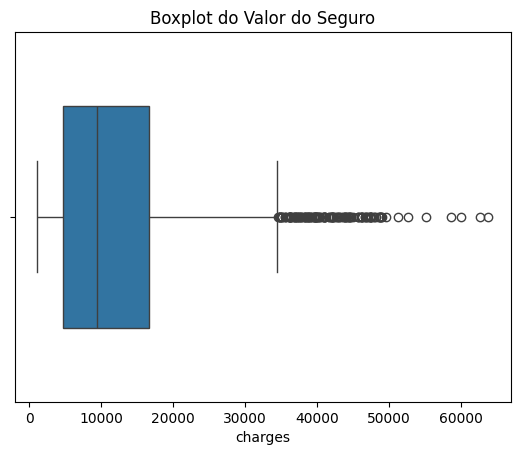

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

pdf = dados.select(dados.columns)

sns.boxplot(data=pdf.toPandas(), x='charges', width=0.6)
plt.title('Boxplot do Valor do Seguro')
plt.show()

* Gerando o Histograma dos dados do Valor do Seguro - verificar sua frequência

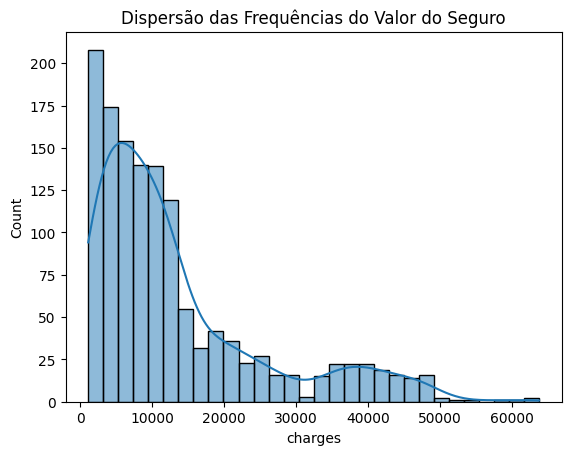

In [0]:
sns.histplot(data=pdf.toPandas(), x='charges', kde=True)
plt.title('Dispersão das Frequências do Valor do Seguro')
plt.show()

* Visualizando gráfico da relação entre as variáveis

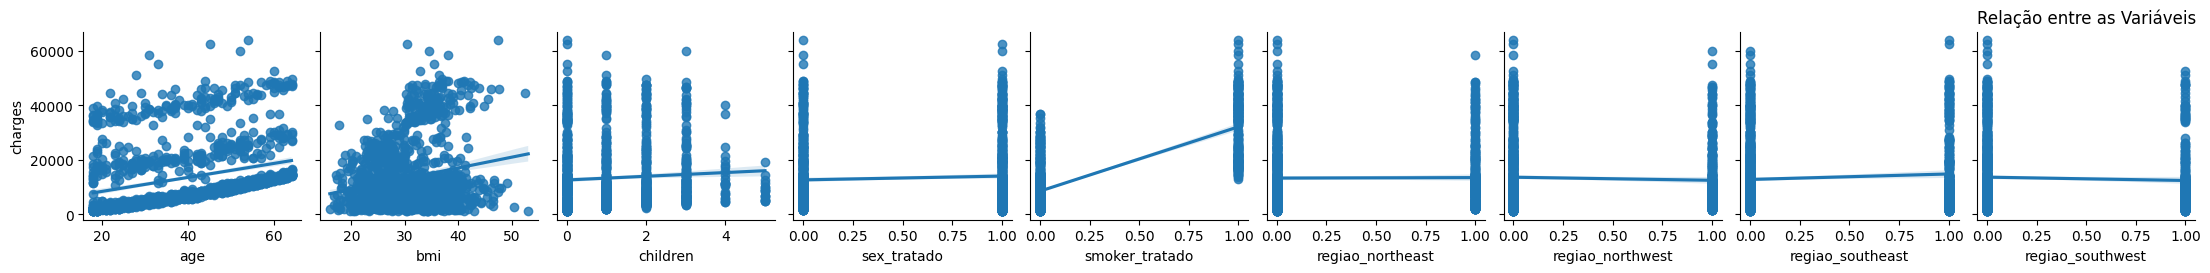

In [0]:
sns.pairplot(data=pdf.toPandas(), y_vars='charges', x_vars=['age',
 'bmi',
 'children',
 'sex_tratado',
 'smoker_tratado',
 'regiao_northeast',
 'regiao_northwest',
 'regiao_southeast',
 'regiao_southwest'], kind='reg')
plt.title('Relação entre as Variáveis')
plt.show()

# 3. Transformação Logarítmica

* Aplicando a Transformação LOG nos dados, melhorando sua distribuição

In [0]:
dados = dados.withColumn('log_age', f.log('age'))\
            .withColumn('log_bmi', f.log('bmi'))\
            .withColumn('log_charges', f.log('charges'))

# Visualizando os Dados depois do Tratamento

* Verificando o gráfica da dispersão dos valores do seguro depois do tratamento LOG

In [0]:
pdf2 = dados.select(dados.columns)

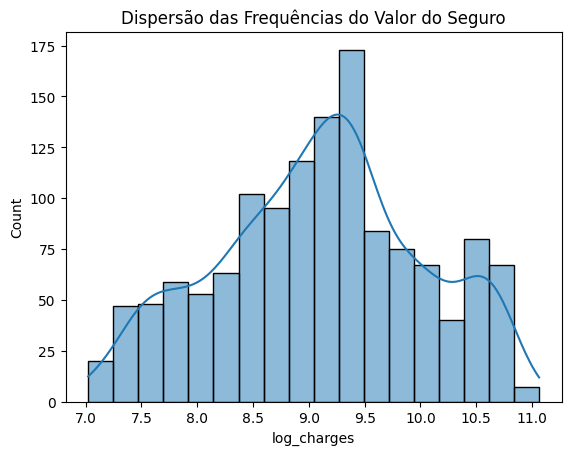

In [0]:
sns.histplot(data=pdf2.toPandas(), x='log_charges', kde=True)
plt.title('Dispersão das Frequências do Valor do Seguro')
plt.show()

* Verificando os gráficos de dispersão entre as variáveis

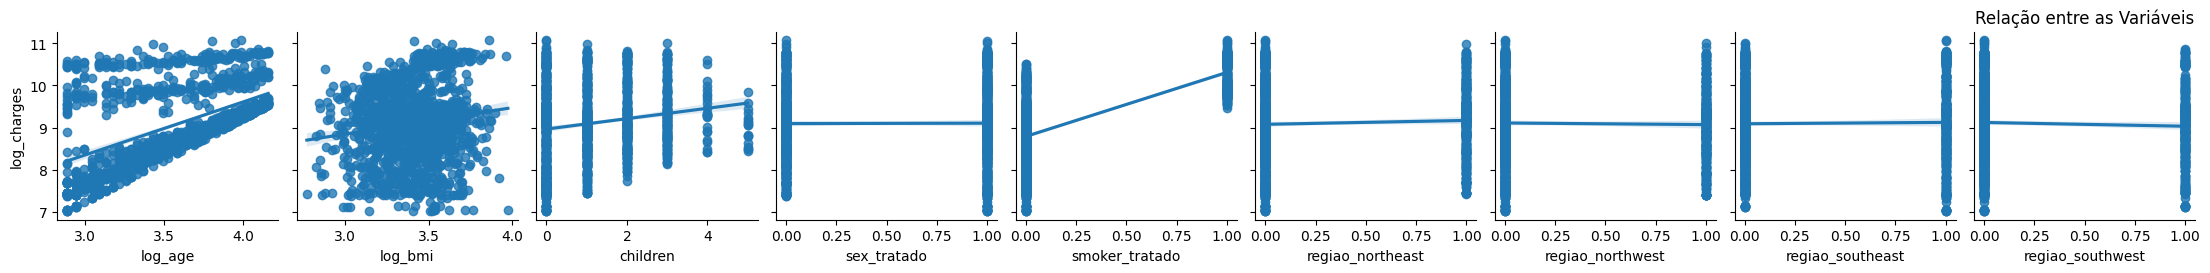

In [0]:
sns.pairplot(data=pdf2.toPandas(), y_vars='log_charges', x_vars=['log_age',
 'log_bmi',
 'children',
 'sex_tratado',
 'smoker_tratado',
 'regiao_northeast',
 'regiao_northwest',
 'regiao_southeast',
 'regiao_southwest'], kind='reg')
plt.title('Relação entre as Variáveis')
plt.show()

# 4. Vetorizando os Dados + Separação para Treinamento

In [0]:
from pyspark.ml.feature import VectorAssembler

* Modificando o nome da variável alvo para Label

In [0]:
dados = dados.withColumnRenamed('log_charges', 'label')

In [0]:
X = dados.columns
X.remove('charges')
X.remove('label')
X.remove('id')
X.remove('age')
X.remove('bmi')
X

['children',
 'sex_tratado',
 'smoker_tratado',
 'regiao_northeast',
 'regiao_northwest',
 'regiao_southeast',
 'regiao_southwest',
 'log_age',
 'log_bmi']

In [0]:
assembler = VectorAssembler(inputCols=X, outputCol='features')

df = assembler.transform(dados).select('features', 'label')

df.show(5, False)

+-------------------------------------------------------------------+-----------------+
|features                                                           |label            |
+-------------------------------------------------------------------+-----------------+
|(9,[2,6,7,8],[1.0,1.0,2.9444389791664403,3.32862668882732])        |9.734176431773115|
|[1.0,1.0,0.0,0.0,0.0,1.0,0.0,2.8903717578961645,3.5195728343974766]|7.453302452133774|
|[3.0,1.0,0.0,0.0,0.0,1.0,0.0,3.332204510175204,3.4965075614664802] |8.400538468975023|
|(9,[1,4,7,8],[1.0,1.0,3.4965075614664802,3.1225851645499145])      |9.998091601725266|
|(9,[1,4,7,8],[1.0,1.0,3.4657359027997265,3.3631493140246254])      |8.260196845858372|
+-------------------------------------------------------------------+-----------------+
only showing top 5 rows


* Fazendo a Separação dos Dados de Treino e Teste

In [0]:
treino, teste = df.randomSplit([0.8, 0.2], seed=123)

In [0]:
print(f'Treino -> {treino.count()}')
print(f'Teste -> {teste.count()}')

Treino -> 1070
Teste -> 268


# 5. Modelos de Machine Learning

# Regressão Linear

In [0]:
from pyspark.ml.regression import LinearRegression

* Treinando o modelo de Regressão Linear

In [0]:
lr = LinearRegression()
modelo_lr = lr.fit(treino)

In [0]:
previsoes_lr_treino = modelo_lr.transform(treino)
previsoes_lr_teste = modelo_lr.transform(teste)

* Mostrando as previsões do Teste

In [0]:
previsoes_lr_teste.show(5, False)

+-------------------------------------------------------------+-----------------+-----------------+
|features                                                     |label            |prediction       |
+-------------------------------------------------------------+-----------------+-----------------+
|(9,[0,3,7,8],[1.0,1.0,3.295836866004329,3.4780040899019204]) |9.847101914674951|8.532227643272897|
|(9,[0,3,7,8],[1.0,1.0,3.4011973816621555,3.1309185461090587])|8.459463236630816|8.517708628174972|
|(9,[0,3,7,8],[1.0,1.0,3.713572066704308,3.0798436161726435]) |9.527008643928893|8.88973837084098 |
|(9,[0,3,7,8],[1.0,1.0,3.713572066704308,3.454264102598848])  |8.90356730735587 |9.048652138207125|
|(9,[0,3,7,8],[1.0,1.0,3.8712010109078907,3.3090820927543496])|9.153492987408674|9.185703710570728|
+-------------------------------------------------------------+-----------------+-----------------+
only showing top 5 rows


* Verificando as Métricas - R² e RMSE

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

In [0]:
evaluator = RegressionEvaluator()

print('Regressão Linear')
print("="*30)
print("Dados de Treino")
print("="*30)
print(f"R²: {evaluator.evaluate(previsoes_lr_treino, {evaluator.metricName: "r2"})}")
print(f"RMSE: {evaluator.evaluate(previsoes_lr_treino, {evaluator.metricName: "rmse"})}")
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print(f"R²: {evaluator.evaluate(previsoes_lr_teste, {evaluator.metricName: "r2"})}" )
print(f"RMSE: { evaluator.evaluate(previsoes_lr_teste, {evaluator.metricName: "rmse"})}")

Regressão Linear
Dados de Treino
R²: 0.7806364155462764
RMSE: 0.4351784425207041

Dados de Teste
R²: 0.7127778019722257
RMSE: 0.46816110790323046


# Random Forest

In [0]:
from pyspark.ml.regression import RandomForestRegressor

* Treinando o Modelo de Random Forest

In [0]:
rf = RandomForestRegressor()
modelo_rf = rf.fit(treino)

In [0]:
previsoes_rf_treino = modelo_rf.transform(treino)
previsoes_rf_teste = modelo_rf.transform(teste)


In [0]:
evaluator = RegressionEvaluator()

print('Random Forest')
print("="*30)
print("Dados de Treino")
print("="*30)
print(f"R²: {evaluator.evaluate(previsoes_rf_treino, {evaluator.metricName: "r2"})}")
print(f"RMSE: {evaluator.evaluate(previsoes_rf_treino, {evaluator.metricName: "rmse"})}")
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print(f"R²: {evaluator.evaluate(previsoes_rf_teste, {evaluator.metricName: "r2"})}" )
print(f"RMSE: { evaluator.evaluate(previsoes_rf_teste, {evaluator.metricName: "rmse"})}")

Random Forest
Dados de Treino
R²: 0.8143979392731093
RMSE: 0.40029162470904095

Dados de Teste
R²: 0.7634648432511786
RMSE: 0.4248485902677559


# 6. Resultados

In [0]:
df_plot = previsoes_lr_teste.select('label', 'prediction').toPandas()

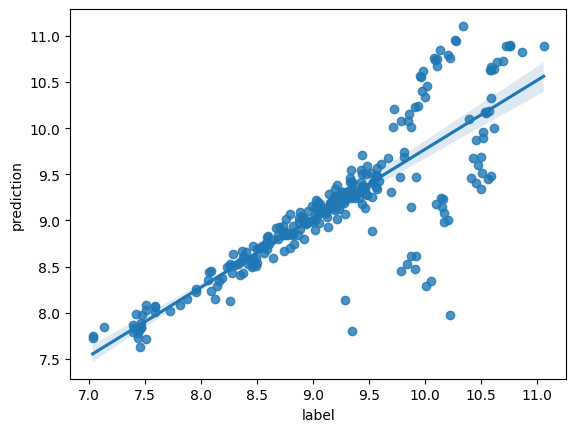

In [0]:
sns.regplot(x='label', y='prediction', data=df_plot)
plt.show()

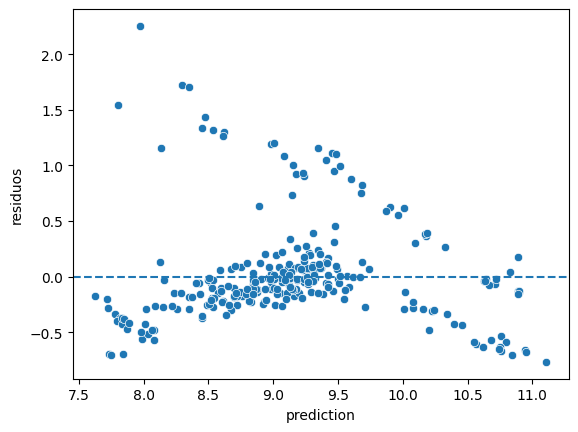

In [0]:
df_plot['residuos'] = df_plot['label'] - df_plot['prediction']

sns.scatterplot(data=df_plot,x='prediction', y='residuos')
plt.axhline(0, linestyle='--')
plt.show()